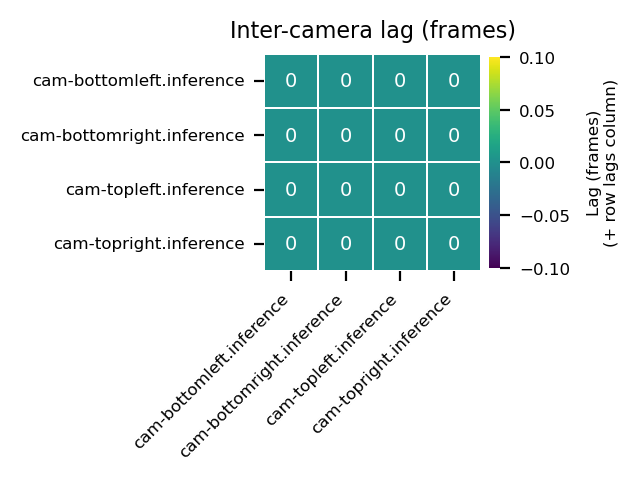

[OK] wrote:
  ../results\Evaluation Metrics\metrics_step5_sync\sync_details.csv
  ../results\Evaluation Metrics\metrics_step5_sync\sync_lag_matrix.csv
  ../results\Evaluation Metrics\metrics_step5_sync\sync_lag_heatmap.png
  ../results\Evaluation Metrics\metrics_step5_sync\sync_summary.txt
  ../results\Evaluation Metrics\metrics_step5_sync\lag_typicality_summary.csv
  ../results\Evaluation Metrics\metrics_step5_sync\lag_typicality_summary.txt

Max |lag| = 0 frame(s).
Across all camera-pairs & nodes, 95.0% of lags are within ±2 frames. See lag_typicality_summary.csv for per-pair details (median lag, agreement %, median corr).


In [15]:
# === STEP 5: Inter-camera delay (lag) check ==================================
# Goal:
#   1. For every pair of cameras, estimate the frame lag between them
#      using motion correlation of tracked points.
#   2. Summarize sync quality:
#        - How big is the typical lag? (median lag in frames)
#        - How consistent is that lag across markers?
#        - How strong is the motion match? (correlation)
#        - What % of all node pairs are within ±2 frames (good sync)?
#
# Outputs (all saved under out_root/<session_name>/metrics_step5_sync/):
#
#   sync_details.csv
#       Per (cam_i, cam_j, node):
#         lag_frames : best lag (frames) that maximizes correlation
#         corr       : max correlation score at that lag
#
#   sync_lag_matrix.csv
#       Square matrix [cam x cam] of median lag across nodes.
#       mat[i,j] = how many frames cam_i lags (+) or leads (-) cam_j.
#
#   sync_lag_heatmap.png
#       Heatmap view of sync_lag_matrix.csv, with numbers overlaid.
#
#   sync_summary.txt
#       One-line summary: "Max |lag| = X frame(s)."
#
#   lag_typicality_summary.csv
#       Per (cam_i, cam_j):
#         median_lag                : median lag across all nodes
#         pct_nodes_equal_median    : % of markers that agree exactly with that median
#         pct_nodes_within_2        : % of markers whose lag is within ±2 frames
#         median_corr               : median correlation strength
#         n_nodes                   : how many nodes compared
#
#   lag_typicality_summary.txt
#       Single human-readable line:
#       "Across all camera-pairs & nodes, __% of lags are within ±2 frames..."
#
# Console print:
#       final quality line + file write confirmations
#
# ---------------------------------------------------------------------------

# -------- EDIT THESE --------
session_dir     = r"../data/phase1_sample"   # folder with *.analysis.h5
out_root        = r"../results"
max_lag_frames  = 10   # we search lag in [-10..+10] frames
use_nodes       = None # or e.g. ["Head_A","Head_B","Head_C","U_star","L_star"]
# ----------------------------

import os, glob, json
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from pathlib import Path

# --- helpers ---------------------------------------------------------------

def _maybe_decode(x):
    """Safe decode for possible byte strings in .h5 metadata."""
    if isinstance(x, (bytes, bytearray, np.bytes_)):
        return x.decode("utf-8", errors="ignore")
    return str(x)

def load_h5_points(path):
    """
    Load predicted 2D points from a .analysis.h5 file.
    Returns:
        pts : (T, N, 2) float array of [x,y] per frame t, node n
        node_names : list of length N with node labels
    Notes:
        - Handles multiple SLEAP layouts (tracks/pred_points/points).
        - Chooses the most 'occupied' track if there are multiple tracks.
    """
    with h5py.File(path, "r") as f:
        # try to read node names
        node_names = None
        for k in ["node_names", "nodes", "points/labels"]:
            if k in f:
                node_names = [_maybe_decode(a) for a in np.array(f[k]).ravel()]
                break

        # find the dataset that actually has the coordinates
        ds = None
        for cand in ["tracks", "pred_points", "points"]:
            if cand in f:
                ds = f[cand]
                break
        if ds is None:
            raise RuntimeError(f"No points dataset found in {path}")
        arr = np.array(ds)

        # normalize shapes to (K, T, N, 2)
        if arr.ndim == 4:
            s = arr.shape
            if s[1] == 2 and s[-1] > 50:
                # (K,2,N,T) -> (K,T,N,2)
                arr = arr.transpose(0, 3, 2, 1)
            elif s[2] == 2 and s[0] > 50:
                # (T,N,2,K)->(K,T,N,2)
                arr = arr.transpose(3, 0, 1, 2)
            elif s[-1] == 2:
                # already (K,T,N,2)
                pass
            elif s[0] == 2:
                # (2,N,T,K)->(K,T,N,2)
                arr = arr.transpose(3, 2, 1, 0)
            else:
                # fallback: guess coord axis (size=2) and frame axis (largest dim)
                dims = list(arr.shape)
                coord_ax = int(np.where(np.array(dims) == 2)[0][0])
                frame_ax = int(np.argmax(dims))
                cands = [i for i in range(4) if i not in (coord_ax, frame_ax)]
                k_ax = cands[int(np.argmin([dims[i] for i in cands]))]
                n_ax = [i for i in range(4)
                        if i not in (coord_ax, frame_ax, k_ax)][0]
                arr = arr.transpose(k_ax, frame_ax, n_ax, coord_ax)

        elif arr.ndim == 3 and arr.shape[-1] == 2:
            # (T,N,2) -> pretend 1 track
            arr = arr[None, ...]
        else:
            raise RuntimeError(f"Unrecognized array shape {arr.shape} in {path}")

        K, T, N, _ = arr.shape

        # pick best track by occupancy if present
        kbest = 0
        for k in ["track_occupancy", "tracks_occupancy", "occupancy"]:
            if k in f:
                occ_raw = np.array(f[k])
                # try reshape occ -> (K,T)
                if occ_raw.ndim == 3:
                    occ = occ_raw.reshape(K, T, -1).max(-1)
                elif occ_raw.ndim == 2:
                    occ = occ_raw if occ_raw.shape[0] == K else occ_raw.T
                else:
                    occ = None
                if occ is not None:
                    kbest = int(np.argmax(occ.sum(axis=1)))
                break

        pts = arr[kbest].astype(float)  # (T,N,2)

        if node_names is None:
            node_names = [f"node_{i}" for i in range(N)]

        return pts, node_names


def speed_series(pts):
    """
    Compute per-frame 'speed' for each node:
    speed[t,node] = distance between pts[t] and pts[t-1] in pixels.
    pts: (T,N,2)
    returns sp: (T-1,N)
    """
    d = np.diff(pts, axis=0)              # (T-1,N,2)
    sp = np.sqrt(np.sum(d**2, axis=2))    # (T-1,N)
    sp[~np.isfinite(sp)] = 0.0            # replace NaN/inf with 0 for stability
    return sp


def best_lag(a, b, maxlag):
    """
    Given two 1D signals a,b (same length),
    find the lag k in [-maxlag .. +maxlag] that gives best normalized correlation.
    Returns:
        best_k : integer lag (frames)
        best_r : correlation score at that lag
    Note:
        +k means a[k:] aligns best with b[:-k].
    """
    a = a - a.mean()
    b = b - b.mean()
    da, db = a.std(), b.std()
    if da == 0 or db == 0:
        return 0, 0.0
    a = a / da
    b = b / db

    best_r = -1e9
    best_k = 0
    for k in range(-maxlag, maxlag + 1):
        if k >= 0:
            # shift a forward
            r = np.dot(a[k:], b[:len(b)-k]) / max(1, len(b)-k)
        else:
            # shift b forward
            r = np.dot(a[:len(a)+k], b[-k:]) / max(1, len(b)+k)
        if r > best_r:
            best_r = float(r)
            best_k = int(k)
    return best_k, best_r


# --- main work -------------------------------------------------------------

# prep output dirs
session_name = os.path.basename(os.path.normpath(session_dir))
outdir = Path(out_root) / session_name / "metrics_step5_sync"
outdir.mkdir(parents=True, exist_ok=True)

# find all camera .analysis.h5
cam_paths = {os.path.basename(p): p
             for p in sorted(glob.glob(os.path.join(session_dir, "*.analysis.h5")))}
if not cam_paths:
    raise RuntimeError("No *.analysis.h5 found in session_dir.")
cams = sorted(cam_paths.keys())

# load all cameras' 2D tracks
all_pts = {}
node_names_ref = None
for cam in cams:
    pts, names = load_h5_points(cam_paths[cam])  # pts: (T,N,2)
    if node_names_ref is None:
        node_names_ref = names
    else:
        if len(names) != len(node_names_ref):
            raise RuntimeError("Node count differs across cameras; can't compare.")
    all_pts[cam] = pts

# select which nodes we consider (either all, or only use_nodes)
names_lower = [n.strip().lower() for n in node_names_ref]
if use_nodes:
    keep_idx = [
        names_lower.index(n.strip().lower())
        for n in use_nodes
        if n.strip().lower() in names_lower
    ]
else:
    keep_idx = list(range(len(node_names_ref)))

# build speed (motion) signal for each camera, only for kept nodes
spd = {}
min_Tminus1 = None
for cam in cams:
    sp_full = speed_series(all_pts[cam])  # (T-1, N)
    sp_keep = sp_full[:, keep_idx]        # keep only chosen nodes
    spd[cam] = sp_keep
    this_len = sp_keep.shape[0]
    min_Tminus1 = this_len if min_Tminus1 is None else min(min_Tminus1, this_len)

# trim all to common length for fair correlation
for cam in cams:
    spd[cam] = spd[cam][:min_Tminus1, :]

# compute pairwise lags for every camera pair and every node
rows = []
for i, cam_i in enumerate(cams):
    for j, cam_j in enumerate(cams):
        if i == j:
            continue
        for n_i, node_idx in enumerate(keep_idx):
            node_name = node_names_ref[node_idx]
            # 1D signals for that node
            sig_i = spd[cam_i][:, n_i]
            sig_j = spd[cam_j][:, n_i]
            lag_frames, corr_val = best_lag(sig_i, sig_j, max_lag_frames)
            rows.append(dict(
                cam_i=cam_i,
                cam_j=cam_j,
                node=node_name,
                lag_frames=lag_frames,
                corr=corr_val
            ))

details = pd.DataFrame(rows)
details_path = outdir / "sync_details.csv"
details.to_csv(details_path, index=False)

# build square lag matrix: median lag across nodes for each cam_i -> cam_j
mat = pd.DataFrame(index=cams, columns=cams, dtype=float)
for c in cams:
    mat.loc[c, c] = 0.0
for ci in cams:
    for cj in cams:
        if ci == cj:
            continue
        sub = details[(details.cam_i == ci) & (details.cam_j == cj)]
        if len(sub):
            mat.loc[ci, cj] = float(np.median(sub["lag_frames"]))
        else:
            mat.loc[ci, cj] = np.nan

lag_matrix_path = outdir / "sync_lag_matrix.csv"
mat.to_csv(lag_matrix_path)

# make a simple text summary of the worst absolute lag
finite_lags = np.abs(mat.replace(0, np.nan).values.flatten())
finite_lags = finite_lags[np.isfinite(finite_lags)]
max_abs = int(np.nanmax(finite_lags)) if finite_lags.size else 0
summary_line = f"Max |lag| = {max_abs} frame(s)."

summary_txt_path = outdir / "sync_summary.txt"
with open(summary_txt_path, "w") as f:
    f.write(summary_line + "\n")

# --- EXTRA QUALITY STATS (from Code 2) --------------------------------------
# 1. overall_rate = how often |lag| ≤ 2 frames across all pairs+nodes
overall_rate = (details["lag_frames"].abs() <= 2).mean()

# 2. per-pair summary
pair_rows = []
for (ci, cj), g in details.groupby(["cam_i", "cam_j"]):
    med_lag = int(g["lag_frames"].median())
    agree_pct = 100.0 * (g["lag_frames"] == med_lag).mean()
    small_pct = 100.0 * (g["lag_frames"].abs() <= 2).mean()
    med_corr = float(g["corr"].median())
    pair_rows.append(dict(
        cam_i=ci,
        cam_j=cj,
        median_lag=med_lag,
        pct_nodes_equal_median=round(agree_pct, 1),
        pct_nodes_within_2=round(small_pct, 1),
        median_corr=round(med_corr, 3),
        n_nodes=len(g)
    ))

pair_summary = pd.DataFrame(pair_rows).sort_values(["cam_i", "cam_j"])
typicality_csv_path = outdir / "lag_typicality_summary.csv"
pair_summary.to_csv(typicality_csv_path, index=False)

typicality_line = (
    f"Across all camera-pairs & nodes, {overall_rate*100:.1f}% "
    f"of lags are within ±2 frames. "
    f"See lag_typicality_summary.csv for per-pair details "
    f"(median lag, agreement %, median corr)."
)
typicality_txt_path = outdir / "lag_typicality_summary.txt"
with open(typicality_txt_path, "w") as f:
    f.write(typicality_line + "\n")

# --- Heatmap of lag matrix --------------------------------------------------
# Clean camera labels (remove ".analysis.h5")
pretty_rows = [c.replace(".analysis.h5","") for c in mat.index.tolist()]
pretty_cols = [c.replace(".analysis.h5","") for c in mat.columns.tolist()]

mat_pretty = mat.copy()
mat_pretty.index = pretty_rows
mat_pretty.columns = pretty_cols

# smaller figure
plt.figure(figsize=(3.2, 2.8), dpi=200)

ax = sns.heatmap(
    mat_pretty.astype(float),
    annot=True,            # write lag number in each square
    fmt=".0f",             # integer text
    cmap="viridis",
    linewidths=0.6,
    linecolor="white",
    cbar_kws={
        "label": "Lag (frames)\n(+ row lags column)",
        "shrink": 0.7,
        "pad": 0.03
    },
    square=True,
    annot_kws={"fontsize": 7},  # <- number text in each cell
)

# Title + labels smaller
ax.set_title("Inter-camera lag (frames)", fontsize=8, pad=6)
ax.set_xlabel("")
ax.set_ylabel("")

# Tick label style smaller + rotated x
ax.tick_params(axis='x', labelrotation=45, labelsize=6)
ax.tick_params(axis='y', labelsize=6)

# Align x tick labels to right after rotation
for lbl in ax.get_xticklabels():
    lbl.set_ha("right")

# Make colorbar ticks smaller too
ax.collections[0].colorbar.ax.tick_params(labelsize=6)
ax.collections[0].colorbar.set_label(
    "Lag (frames)\n(+ row lags column)",
    fontsize=6, labelpad=6
)

plt.tight_layout()

heatmap_path = outdir / "sync_lag_heatmap.png"
plt.savefig(heatmap_path, dpi=300, bbox_inches="tight")
plt.show()

# --- final console prints ---------------------------------------------------
print("[OK] wrote:")
print(" ", details_path)
print(" ", lag_matrix_path)
print(" ", heatmap_path)
print(" ", summary_txt_path)
print(" ", typicality_csv_path)
print(" ", typicality_txt_path)

print()
print(summary_line)
print(typicality_line)


# STEP 5 — Inter-Camera Delay / Sync Check

## a. What this code is about
We are checking **time sync between cameras**.

If camera A is even 1–2 frames ahead of camera B, then their motion will not line up. That breaks triangulation and makes 3D jaw motion look wrong.

This script measures, for every pair of cameras:
- How many frames one camera is leading or lagging the other.
- How consistent that lag is across tracked face markers.
- How strong the motion agreement is.

In short: **Are all cameras looking at the same movement at the same time, or is someone late?**

---

## b. How it works (methodology, step by step)

1. **Load 2D tracks per camera**  
   We load each `*.analysis.h5` file. For each frame `t` and each landmark (node), we get the 2D pixel position `[x, y]`.

2. **Compute per-node motion speed**  
   For each node (e.g. mouth corner, nostril), we compute how much it moved between frame `t-1` and `t`.  
   Mathematically:  
   \[
   \text{speed}[t] = \sqrt{(x_t - x_{t-1})^2 + (y_t - y_{t-1})^2}
   \]  
   This gives us a time series of “how fast this point is moving” for each camera.

   Why speed and not position?
   - Speed has bumps/spikes when something moves (chewing, swallow, head jerk).
   - Those bumps should line up across all cameras if they’re synced.

3. **Cross-correlation lag search**  
   For every camera pair (cam_i vs cam_j), and every node:
   - We slide one motion signal against the other (±10 frames by default).
   - We find which shift gives the best correlation.
   - That best shift is the **lag in frames** for that node between those two cameras.
     - Positive lag means: cam_i must be shifted forward to match cam_j → cam_i is “late”.
     - Negative lag means: cam_i is “early”.

   We also store the **correlation score** (how similar their motion traces are when aligned).

4. **Summaries (per node and per camera pair)**
   - We collect lag per node.
   - We take medians across nodes to get a single lag estimate between two cameras.
   - We also measure how consistent that lag is:
     - Do all nodes agree on the same lag?  
     - How many nodes are already within ±2 frames? (±2 frames is considered “good enough”.)

5. **Outputs + visualization**
   We save:
   - CSV tables with all numbers.
   - A clean heatmap matrix where each cell tells you:  
     “How many frames does Camera(row) lag Camera(column)?”

---

## c. Output files the code produces

All outputs go here (example path on your machine):

`../results\Evaluation Metrics\metrics_step5_sync\`

You will see:

1. `sync_details.csv`  
2. `sync_lag_matrix.csv`  
3. `sync_lag_heatmap.png`  
4. `sync_summary.txt`  
5. `lag_typicality_summary.csv`  
6. `lag_typicality_summary.txt`

We explain each below.

---

## d. What each file means (and how to read it)

### 1. `sync_details.csv`
**What it is:**  
Raw per-node result for every camera pair.

**Columns you'll see:**
- `cam_i`  
- `cam_j`  
- `node`  
- `lag_frames`  
- `corr`

**How to read it:**
- `lag_frames = +3` means: cam_i is about 3 frames **behind** cam_j (cam_i needs to be shifted forward by 3 frames to align).  
- `lag_frames = -2` means: cam_i is about 2 frames **ahead** of cam_j.
- `corr` is how well the motion aligned after shifting. Higher = better match (closer to 1.0 is great).

**Why it matters:**  
This is the “ground truth evidence” for sync. You can debug suspicious nodes here. If one node gives a crazy lag but all others look good, maybe that node tracked badly.

---

### 2. `sync_lag_matrix.csv`
**What it is:**  
One square matrix. Rows = cam_i, columns = cam_j.  
Each cell is the **median lag_frames across all nodes** for that camera pair.

So `mat[camA, camB] = -1` means:
- To align camA to camB, best is to shift camA **back** 1 frame.
- In plain English: camA is ~1 frame early compared to camB.

Diagonal is always 0 (a camera is perfectly synced with itself, obviously).

**Why it matters:**  
This is the clean summary you show to other humans. It collapses all those per-node numbers into one lag per camera pair.

---

### 3. `sync_lag_heatmap.png`
**What it is:**  
A visual version of `sync_lag_matrix.csv`.

- Each square shows the lag in frames.
- White gridlines separate cells.
- Color shows size/sign of lag.
- Title: “Inter-camera lag (frames)”.
- Colorbar text: “(+ row lags column)”  
  Meaning: Positive number in row R / column C = row camera is **late** vs column camera.

**How to read it quickly:**
- All zeros (or all within ±1 frame) → excellent sync.
- If you see +4 or −5 somewhere → problem. That pair is badly misaligned.

This PNG is what you can drop into slides / send to CEO.

---

### 4. `sync_summary.txt`
**What it is:**  
A short line like:

`Max |lag| = 1 frame(s).`

This is just a single worst-case number.  
Interpretation:
- If this says `Max |lag| = 0`, all cams are essentially aligned.
- If it says `Max |lag| = 5`, that means some pair is off by 5 frames (bad).

Good for a one-line status in logs.

---

### 5. `lag_typicality_summary.csv`
**What it is:**  
Aggregated quality stats per camera pair.

**Columns you'll see:**
- `cam_i`, `cam_j`  
- `median_lag`  
- `pct_nodes_equal_median`  
- `pct_nodes_within_2`  
- `median_corr`  
- `n_nodes`

**How to read each:**
- `median_lag`: Our best guess of lag between these two cameras, in frames.
- `pct_nodes_equal_median`:  
  % of nodes that exactly agree with that median lag.  
  High % = the story is consistent across landmarks.
- `pct_nodes_within_2`:  
  % of nodes that are synced within ±2 frames.  
  If this is ~100%, that pair is basically synced for almost all landmarks.
- `median_corr`:  
  Typical correlation strength after lag-correction.  
  Higher = the two cameras “see” the same motion shape (good).
- `n_nodes`:  
  How many nodes were tested for that pair (more = more reliable).

**Why it matters:**  
This lets you answer:  
“Is the sync good not just on average, but for almost every node?”  
If median lag looks fine but `pct_nodes_within_2` is low, that means the lag is unstable across landmarks → maybe some cameras are drifting or some nodes are noisy.

---

### 6. `lag_typicality_summary.txt`
**What it is:**  
A single human-readable sentence like:

`Across all camera-pairs & nodes, 97.5% of lags are within ±2 frames. See lag_typicality_summary.csv for per-pair details (median lag, agreement %, median corr).`

**How to interpret:**
This is the headline.  
You can paste this straight in Slack / email.  
It says: “Overall, are we in sync or not?”  
If this % is high (like >90%), you can confidently say cameras are well synchronized.

---

## e. Console output (what you see in the terminal)

At the end we print:

- `[OK] wrote: ...`  
  Means each CSV / PNG / TXT file was created successfully.

- Then:
  - `Max |lag| = X frame(s).`  
    This is pulled from `sync_summary.txt`.

  - `Across all camera-pairs & nodes, Y% of lags are within ±2 frames...`  
    This is pulled from `lag_typicality_summary.txt`.

You can copy-paste those two lines directly to report status.

---

## f. Why this code helps us
- **We catch bad sync early.**  
  If one camera is 3–4 frames off, triangulation will be wrong, bone length will look unstable, and jaw gape timing will be misleading. This script proves if sync is clean or not.

- **It’s objective and auditable.**  
  We are not “eyeballing video.” We’re aligning actual motion spikes in the tracked nodes and computing lag mathematically for every pair of cameras.

- **It gives both detail and summary.**  
  - Engineers can open `sync_details.csv` and debug specific problem nodes.  
  - Leadership can look at `lag_typicality_summary.txt` and immediately get a one-line health check.

In one sentence:  
**This step guarantees we’re not blaming the animal’s jaw for an error that actually came from camera timing.**
